Here, I am training an ML model to learn from the electrocardiogram (ECG) signals representing different types of heartbeats to identify the 4 types of heartbeats: 

1) "Normal"
2) "Supraventricular Arrhythmia"
3) "Ventricular Arrhythmia"
4) "Ventricular-Normal Fusion"
5) "Paced-Normal Fusion"


Traditional model like RNN or LSTM can b used for this task. However, my objective here is to explore the capabilities of LLM Language Vision model based on Transformer, to see to what extent it can learn to predict an ECG signal.

In [1]:
# pip install imbalanced-learn matplotlib pandas numpy tqdm gdown

import os
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from PIL import Image
from tqdm.notebook import tqdm
import multiprocessing
from joblib import Parallel, delayed

pd.options.display.max_rows = 5

In [2]:
if False: 
    !gdown https://drive.google.com/uc?id=19En9_JPWpdp9NlZIMV6hmIgOW4Uti4y8

    import shutil
    shutil.unpack_archive('input.zip') 

In [3]:
df_mitbih_train = pd.read_csv('input/mitbih_train.csv', header=None)
df_mitbih_test  = pd.read_csv('input/mitbih_test.csv', header=None)
print(df_mitbih_train.shape, df_mitbih_test.shape)

# 187 column looks like a target column. We already see the skewiness  
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)
df_mitbih_test.rename(columns={187: 'class'}, inplace=True)

df_mitbih_train

(87554, 188) (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87553,0.901506,0.845886,0.800695,0.748552,0.687138,0.599073,0.512167,0.427578,0.395133,0.402086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [4]:
# There are no NaNs 

df_mitbih_train.isnull().sum(axis=0).sum(), df_mitbih_test.isnull().sum(axis=0).sum()

(np.int64(0), np.int64(0))

In [5]:
# No duplicated data

print(f"Duplicated values in train data: {df_mitbih_train.duplicated().sum()}")
print(f"Duplicated values in test data: {df_mitbih_test.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


In [6]:
# The Class target looks like categorical rather than ordinal data. So convert 

id_to_label = { 
    0: "Normal",
    1: "Supraventricular Arrhythmia",
    2: "Ventricular Arrhythmia",
    3: "Ventricular-Normal Fusion",
    4: "Paced-Normal Fusion" }


df_mitbih_train['class'] = df_mitbih_train['class'].replace(id_to_label)
df_mitbih_test['class']  = df_mitbih_test['class'].replace(id_to_label)

In [7]:
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0).reset_index(drop=True)
df_mitbih

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109444,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paced-Normal Fusion
109445,0.973970,0.913232,0.865510,0.823210,0.746204,0.642082,0.547722,0.426247,0.325380,0.279826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paced-Normal Fusion


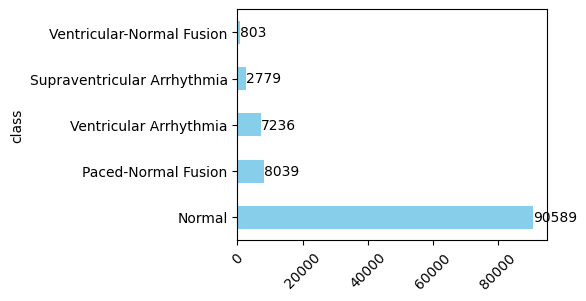

In [8]:
# Data is very skewed: Train + Test data 

plt.figure(figsize=(4,3)) 
df_mitbih['class'].value_counts().plot(kind='barh', color='skyblue')
plt.xticks(rotation=45);

for index, value in enumerate(df_mitbih['class'].value_counts()):
    plt.text(value, index, str(value), va='center'); 

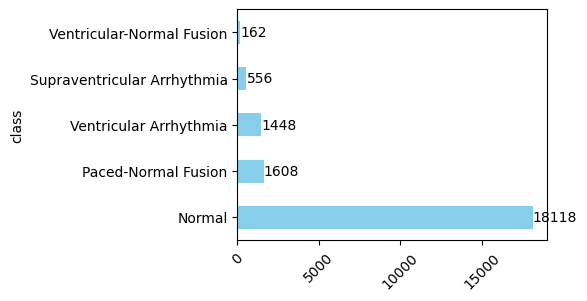

In [9]:
# Test data 

plt.figure(figsize=(4,3)) 
df_mitbih_test['class'].value_counts().plot(kind='barh', color='skyblue')
plt.xticks(rotation=45);

for index, value in enumerate(df_mitbih_test['class'].value_counts()):
    plt.text(value, index, str(value), va='center'); 

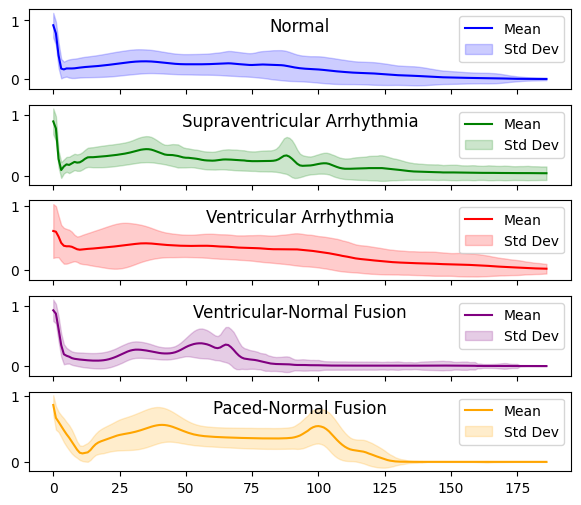

In [10]:
# For each of the category, let's plot the mean and std values, not to plot the whole cohort

categories = id_to_label.values()

fig, axs = plt.subplots(len(categories), figsize=(7, 6), sharex=True)
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, (category, color) in enumerate(zip(categories, colors)):
    to_plot = df_mitbih.loc[df_mitbih['class'] == category, :186]
    mean_values = to_plot.mean()
    std_values = to_plot.std()

    axs[i].plot(mean_values, label='Mean', color=color)
    axs[i].fill_between(range(len(mean_values)), 
                        mean_values - std_values, 
                        mean_values + std_values, 
                        color=color, alpha=0.2, label='Std Dev')
    axs[i].set_title(f'{category}', y=0.8, va="top"); axs[i].legend(); 

In [11]:
# Apply oversampling only to the train data, and not to the test data

X = df_mitbih_train .drop(columns=['class'])
y = df_mitbih_train['class']

# 20% of the Normal (biggest) class
sampling_strategy = {
    "Normal":                      int(y.value_counts()["Normal"]),  
    "Supraventricular Arrhythmia": int(y.value_counts()["Normal"] * 0.2), 
    "Ventricular Arrhythmia":      int(y.value_counts()["Normal"] * 0.2),      
    "Ventricular-Normal Fusion":   int(y.value_counts()["Normal"] * 0.2),   
    "Paced-Normal Fusion":         int(y.value_counts()["Normal"] * 0.2)   }


smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['class'] = y_resampled

df_resampled

/tmp/ipykernel_543/1632457338.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['class'] = y_resampled


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130445,0.967289,1.000000,0.638967,0.361451,0.202603,0.164612,0.134823,0.122892,0.106252,0.109416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventricular-Normal Fusion
130446,1.000000,0.932730,0.699869,0.362576,0.146003,0.137293,0.131825,0.102093,0.089027,0.082466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventricular-Normal Fusion


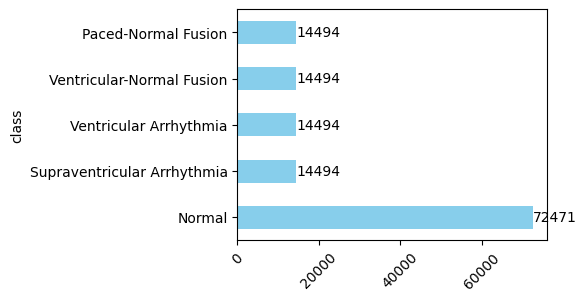

In [12]:
plt.figure(figsize=(4,3)) 
df_resampled['class'].value_counts().plot(kind='barh', color='skyblue')
plt.xticks(rotation=45);

for index, value in enumerate(df_resampled['class'].value_counts()):
    plt.text(value, index, str(value), va='center'); 

In [13]:
# Compare to the original
df_mitbih_train['class'].value_counts(dropna=False) 

class
Normal                         72471
Paced-Normal Fusion             6431
Ventricular Arrhythmia          5788
Supraventricular Arrhythmia     2223
Ventricular-Normal Fusion        641
Name: count, dtype: int64

In [14]:
if True: 
    df_resampled.to_csv('input/mitbih_train_resampled.csv', index=False)
    df_mitbih_test.to_csv('input/mitbih_test_renamed.csv',  index=False)

### Another option is to augment data is to use Generative Adversarial Network (GAN) on the traindata. I have experience using CTGAN, and it provided a great improvement of the model performance. 

# Create an image data

In [14]:
df_resampled   = pd.read_csv('input/mitbih_train_resampled.csv')
df_mitbih_test = pd.read_csv('input/mitbih_test_renamed.csv') 

In [15]:
df_resampled

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130445,0.967289,1.000000,0.638967,0.361451,0.202603,0.164612,0.134823,0.122892,0.106252,0.109416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventricular-Normal Fusion
130446,1.000000,0.932730,0.699869,0.362576,0.146003,0.137293,0.131825,0.102093,0.089027,0.082466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventricular-Normal Fusion


In [ ]:
df_resampled = df_resampled.drop(columns=['class'])

path_images_train = 'input/images/train'
os.makedirs(path_images_train, exist_ok=True)

def save_plot0(index, row):
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(row)), row, linestyle='-', color='black')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.grid(True)
    plt.savefig(os.path.join(path_images_train, f'{index}.png'))
    plt.close()

Parallel(n_jobs=20)(delayed(save_plot0)(index, row) for index, row in df_resampled.iterrows())

In [14]:
# Better to use joblib than multiprocessing as more user-friendly 

df_mitbih_test = df_mitbih_test.drop(columns=['class'])

path_images_test = 'input/images/test'
os.makedirs(path_images_test, exist_ok=True)

def save_plot1(index, row):
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(row)), row, linestyle='-', color='black')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.grid(True)
    plt.savefig(os.path.join(path_images_test, f'{index}.png'))
    plt.close()  

with multiprocessing.Pool(processes=25) as pool:
    pool.starmap(save_plot1, [(index, row) for index, row in df_mitbih_test.iterrows()])

109184


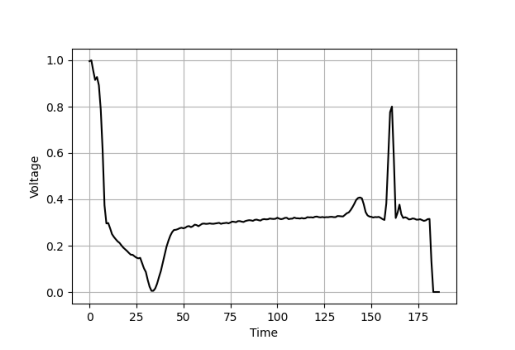

In [5]:
# For example, this is an image file 

path_images_train = 'input/images/train'

image_files = [f for f in os.listdir(path_images_train) if f.endswith('.png')]
print(len(image_files))
image_file = image_files[109183]

image_path = os.path.join(path_images_train, image_file)
image = Image.open(image_path)

plt.imshow(image); plt.axis('off'); 

In [20]:
import shutil

shutil.make_archive('train_images', 'zip', path_images_train)
#shutil.make_archive('test_images', 'zip', path_images_test)

'/home/train_images.zip'

In [16]:
import os
image_files = [f for f in os.listdir('input/images/train') if f.endswith('.png')]
len(image_files)

130447

In [17]:
import os
image_files = [f for f in os.listdir('input/images/test') if f.endswith('.png')]
len(image_files)

21892